## Let's start looking at the communicative context of calls. 
## - Cluster 2 or 3 calls at a time, instead of just 1
## - Start by looking at the intervals between calls
## - I've clustered calls into categories in two different ways and I need to combine them or whatever
## - The biosound H5 files don't have this info, so I'll be extracting it from the soundsep segment filenames


## so far I've found that there is some contamination of the data, primarily sometimes one call gets double labeled as a call on two channels, which then makes it look like a bird is responding extremely quickly to another.
## I'm now excluding these from the dataset, excluding all tets that either come 7.5 ms before or after another tet.

# I need to start making finalish figures for a grant.

## what do I want to do with these gap durations... 
## and then of course the question is how to bring it all back to big ideas.


In [1]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

In [2]:
# we have wav files in a folder, H5 files in a folder, and soundsep data. 

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/'

soundsep_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
wave_files_folder = os.path.join(base_folder,'wavs')
spectrogram_folder = os.path.join(base_folder,'spec_results')

# Load the soundsep data
print(soundsep_file_name)
df = pd.read_csv(soundsep_file_name, sep=',',header=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

# Load the wav filenames to compare with the soundsep data for consistency.
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))

# Load the spectrogram data to compare with the soundsep data for consistency.
spec_cluster_labels = np.load(os.path.join(base_folder,'spec_results','cluster_labels.npy'))


/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv
Length of dataframe: 4344
Column names: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords'],
      dtype='object')
Tags: ['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']


In [5]:
# let's at least make sure the wav files are in the same order as the soundsep data
# we'll just check that the lengths of the wav files are the same as the lengths of the soundsep data
# and that the names are the same (maybe) 
# and that the spectrogram data is the same length as the soundsep data (maybe)

if len(df) != len(wav_list):
    print('Dataframe length does not match wav file length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of wav files: {len(wav_list)}')
else:
    print('Dataframe length matches wav file length')

if len(df) != len(spec_cluster_labels):
    print('Dataframe length does not match cluster label length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of cluster labels: {len(spec_cluster_labels)}')
else:
    print('Dataframe length matches cluster label length')

# TODO - check that the wav files are in the same order as the soundsep data
# TODO - check that the wav files are in the same order as the cluster labels



Dataframe length matches wav file length
Dataframe length matches cluster label length


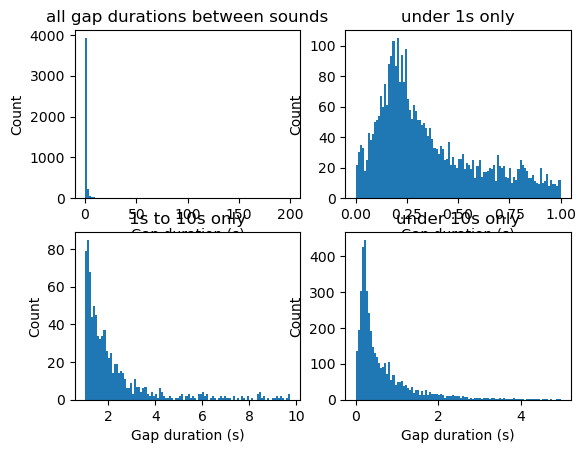

In [4]:
# calculate the gap durations between each sound
# we'll use the soundsep data for this
# df['StartIndex'][0]
df['gap_duration'] = df['StartIndex'].diff()
df['gap_duration'] /= fs

# plot a histogram of the gap durations

plt.figure()
plt.subplot(2,2,1)
plt.hist(df['gap_duration'], bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('all gap durations between sounds')

# plot a histogram of the gap durations zoomed in on the short gaps
# take the gap_durations that are less than 1 second and put them in a variable to make a histogram
short_gap_index = (df['gap_duration'] < 1).values
short_gaps = df['gap_duration'][short_gap_index]
plt.subplot(2,2,2)
plt.hist(short_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('under 1s only')

medium_gap_index = (df['gap_duration'] > 1) & (df['gap_duration'] < 10)
medium_gaps = df['gap_duration'][medium_gap_index]
plt.subplot(2,2,3)
plt.hist(medium_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('1s to 10s only')

shortish_gap_index = (df['gap_duration']  < 5)
shortish_gaps = df['gap_duration'][shortish_gap_index]
plt.subplot(2,2,4)
plt.hist(shortish_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('under 10s only')

plt.show()


# Ok that's surprisingly interesting already.
## I want to calculate which call types follow which call types and what the durations are between different types of call types

In [5]:
for call_type in np.unique(cluster_labels):
    print(f'Call type: {call_type}')
    call_index = (cluster_labels == call_type)
    call_index = call_index & (df['gap_duration'] < 5)
    call_gaps = df['gap_duration'][call_index]
    plt.figure()
    plt.hist(call_gaps, bins=100)
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'spectrogram based call type: {call_type} gap durations')
    plt.show()

NameError: name 'cluster_labels' is not defined

Call type: ["-2"]


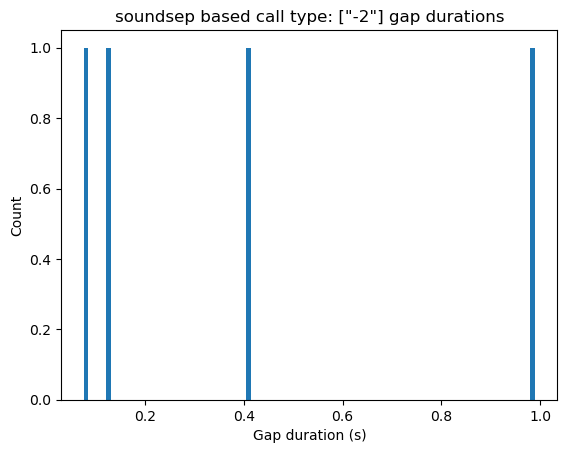

Call type: ["2"]


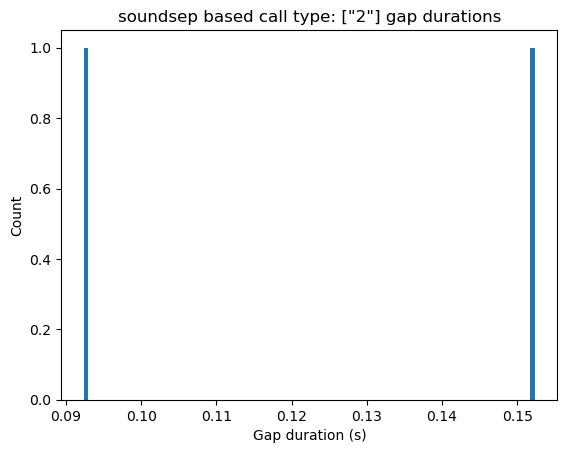

Call type: ["3"]


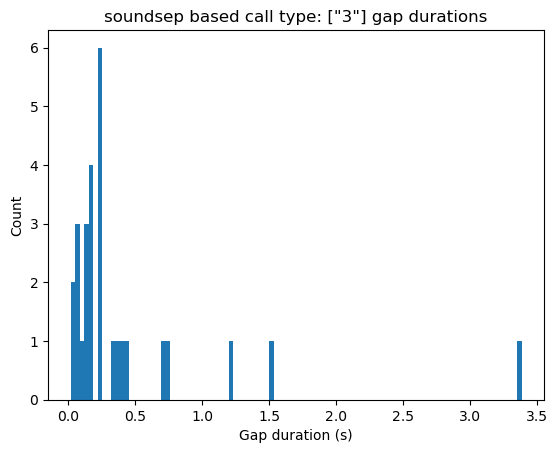

Call type: ["8"]


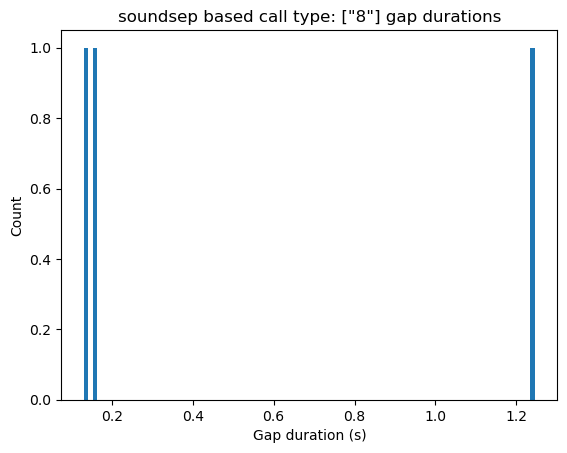

Call type: ["DC"]


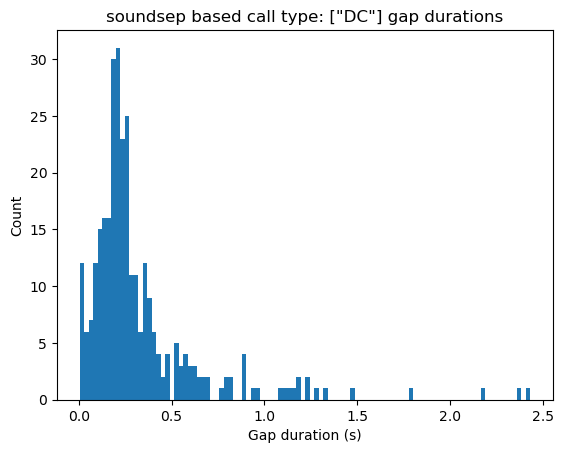

Call type: ["WF"]


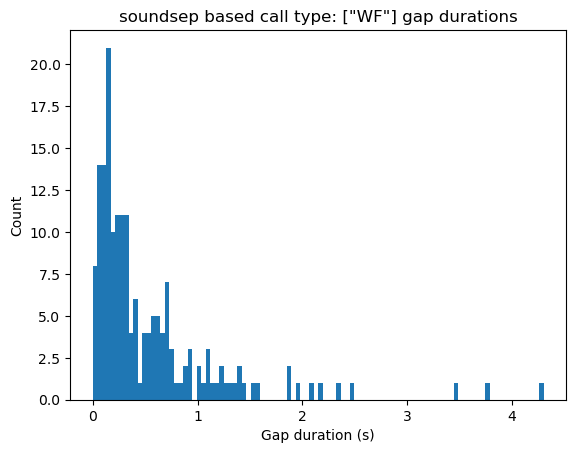

Call type: ["call"]


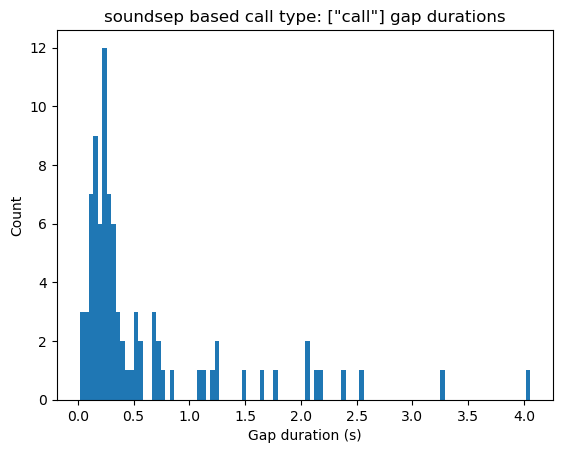

Call type: ["hat"]


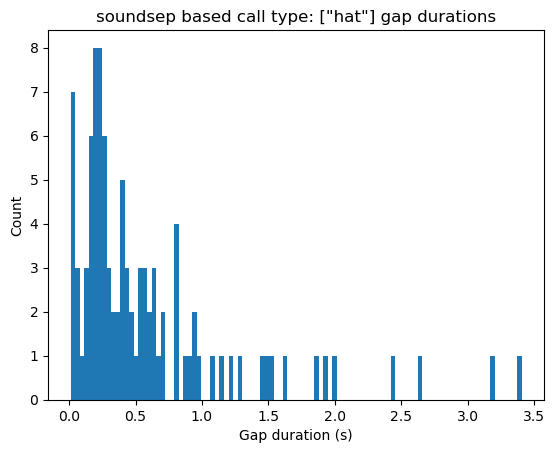

Call type: ["tet"]


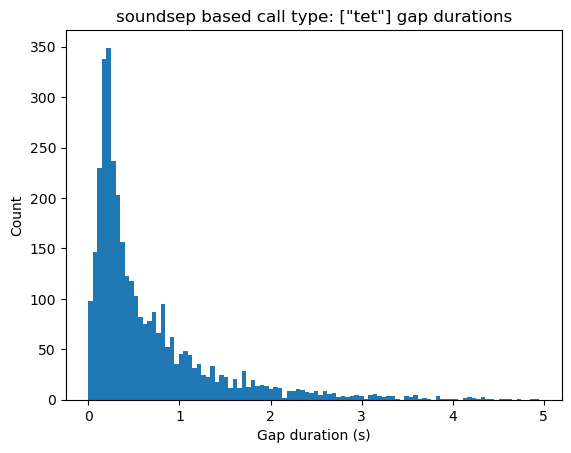

In [6]:
# do the same thing with the labels from the soundsep data
for call_type in np.unique(df['Tags']):
    print(f'Call type: {call_type}')
    call_index = (df['Tags'] == call_type)
    call_index = call_index & (df['gap_duration'] < 5)
    call_gaps = df['gap_duration'][call_index]
    plt.figure()
    plt.hist(call_gaps, bins=100)
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'soundsep based call type: {call_type} gap durations')
    plt.show()

In [7]:
print(df['Tags'][0])
# print the first Tag in the dataframe
if df['Tags'][0] == '["tet"]':
    print('First tag is tet')

["tet"]
First tag is tet


In [8]:
# gap_duration_dict = {bird: [] for bird in birds}
# gap_duration_dict['BluGre1214F'] = {bird: [] for bird in birds}
# gap_duration_dict['BroGre1354M'] = {bird: [] for bird in birds}
# gap_duration_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
# gap_duration_dict['WhiWhi6607F'] = {bird: [] for bird in birds}

# # initialize lists for each bird pair
# gap_duration_dict['BluGre1214F']['BluGre1214F'] = list()
# gap_duration_dict['BluGre1214F']['BroGre1354M'] = list()
# gap_duration_dict['BluGre1214F']['WhiWhi1541M'] = list()
# gap_duration_dict['BluGre1214F']['WhiWhi6607F'] = list()
# gap_duration_dict['BroGre1354M']['BluGre1214F'] = list()
# gap_duration_dict['BroGre1354M']['BroGre1354M'] = list()
# gap_duration_dict['BroGre1354M']['WhiWhi1541M'] = list()
# gap_duration_dict['BroGre1354M']['WhiWhi6607F'] = list()
# gap_duration_dict['WhiWhi1541M']['BluGre1214F'] = list()
# gap_duration_dict['WhiWhi1541M']['BroGre1354M'] = list()
# gap_duration_dict['WhiWhi1541M']['WhiWhi1541M'] = list()
# gap_duration_dict['WhiWhi1541M']['WhiWhi6607F'] = list()
# gap_duration_dict['WhiWhi6607F']['BluGre1214F'] = list()
# gap_duration_dict['WhiWhi6607F']['BroGre1354M'] = list()
# gap_duration_dict['WhiWhi6607F']['WhiWhi1541M'] = list()
# gap_duration_dict['WhiWhi6607F']['WhiWhi6607F'] = list()

# for i in range(len(df)-1):
#     if df['Tags'][i] == '["tet"]':
#         vocalizer = df['SourceName'][i]
#         responder = df['SourceName'][i+1]
#         response = df['Tags'][i+1]
#         if response == '["tet"]':
#             gap_duration = (df['StopIndex'][i]-df['StartIndex'][i])/fs
#             gap_duration_dict[vocalizer][responder].append(gap_duration)

# gap_duration_dict

BroGre1354M to BluGre1214F: 0.06854166666666667, index: 4
BluGre1214F to BroGre1354M: 0.045020833333333336, index: 5
BluGre1214F to BluGre1214F: 0.07441666666666667, index: 7
BluGre1214F to BluGre1214F: 0.053625, index: 8
BluGre1214F to BroGre1354M: 0.05620833333333333, index: 9
BluGre1214F to BluGre1214F: 0.0679375, index: 11
BluGre1214F to BluGre1214F: 0.056625, index: 12
BluGre1214F to BroGre1354M: 0.057541666666666665, index: 13
BluGre1214F to BroGre1354M: 0.071875, index: 19
WhiWhi1541M to BluGre1214F: 0.06383333333333334, index: 21
BluGre1214F to BluGre1214F: 0.046875, index: 22
BluGre1214F to BluGre1214F: 0.058333333333333334, index: 23
BluGre1214F to BroGre1354M: 0.050916666666666666, index: 26
BluGre1214F to BroGre1354M: 0.050604166666666665, index: 29
BluGre1214F to BroGre1354M: 0.060645833333333336, index: 33
WhiWhi1541M to BluGre1214F: 0.05825, index: 40
BluGre1214F to BroGre1354M: 0.046125, index: 41
BluGre1214F to BroGre1354M: 0.05247916666666667, index: 44
BroGre1354M to

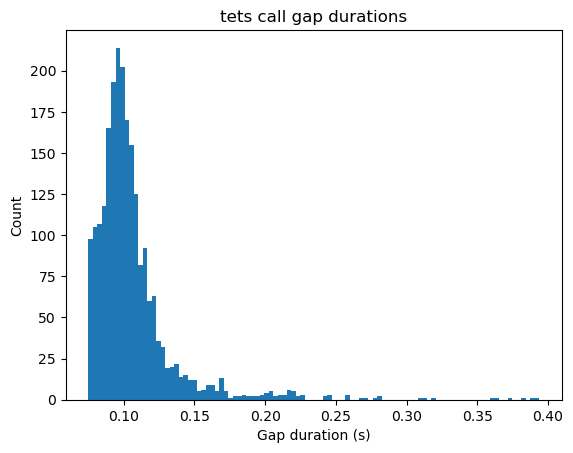

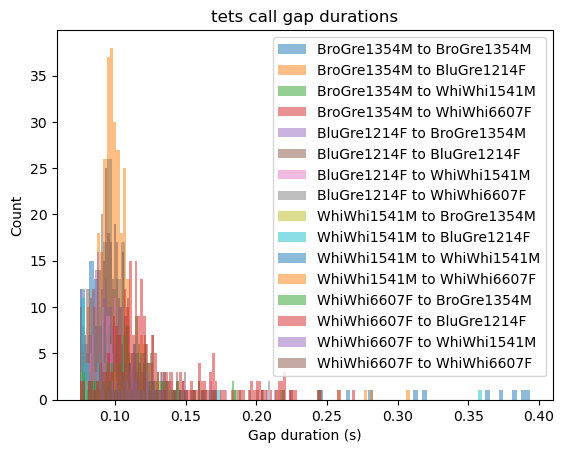

This is how often each bird responds to each other bird


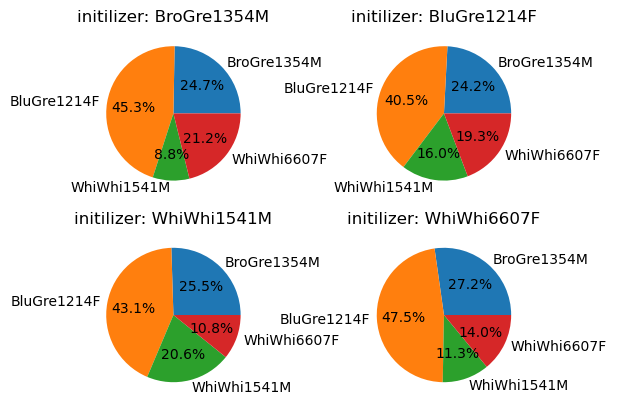

In [9]:
# I want to focus on tets (soundsep based) and look at how quickly birds are calling after each other
# I want to look at the gap durations between tets calls
# let's plot the gap durations between tets calls of different individuals vs the gap durations between tets calls of the same individual
# first, let's get the gap durations between tet calls of all individuals and stick them in a dictionary of dictionaries of lists
birds = df['SourceName'].unique()

gap_duration_dict = {bird: [] for bird in birds}
gap_duration_dict['BluGre1214F'] = {bird: [] for bird in birds}
gap_duration_dict['BroGre1354M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi6607F'] = {bird: [] for bird in birds}

# initialize lists for each bird pair
gap_duration_dict['BluGre1214F']['BluGre1214F'] = list()
gap_duration_dict['BluGre1214F']['BroGre1354M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi1541M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi6607F'] = list()
gap_duration_dict['BroGre1354M']['BluGre1214F'] = list()
gap_duration_dict['BroGre1354M']['BroGre1354M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi1541M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi1541M']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi1541M']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi6607F']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi6607F']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi6607F'] = list()

exclude_by_gap_list = list()
for i in range(len(df)-1):
    if df['Tags'][i] == '["tet"]':
        vocalizer = df['SourceName'][i]
        responder = df['SourceName'][i+1]
        response = df['Tags'][i+1]
        if response == '["tet"]':
            gap_duration = (df['StopIndex'][i]-df['StartIndex'][i])/fs

            if gap_duration < 0.075:
                print(f'{vocalizer} to {responder}: {gap_duration}, index: {i}')
                exclude_by_gap_list.append(i)
            else:
                gap_duration_dict[vocalizer][responder].append(gap_duration)

# gap_duration_dict

# now we have a dictionary of gap durations between each bird
# let's plot the gap durations
# first, let's plot all the gap durations in one histogram
# then, let's plot the gap durations between each pair of birds in a histogram
# then, let's plot a pie chart of how often each bird responds to each other bird

# plot all the gap durations in one histogram, irrespective of who is calling
plt.figure()
all_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        all_gaps += gap_duration_dict[bird1][bird2]
plt.hist(all_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations')


plt.figure()
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        plt.hist(gap_duration_dict[bird1][bird2], bins=100, alpha=0.5, label=f'{bird1} to {bird2}')
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations')
plt.legend()
plt.show()

# let's plot pie charts of how often each bird responds to each other bird
# we'll have 4 pie charts
print(f'This is how often each bird responds to each other bird')
plt.figure()
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    plt.pie([len(gap_duration_dict[bird1][bird2]) for bird2 in gap_duration_dict[bird1]], labels=[bird2 for bird2 in gap_duration_dict[bird1]], autopct='%1.1f%%')
    plt.title(f'initilizer: {bird1}')
plt.show()



In [11]:
# #make a new DF excluding the short gaps
df_exclude = df.drop(exclude_by_gap_list)
len(df_exclude)
df_exclude.to_csv(os.path.join(base_folder,'_appdata','save','segments_exclude_short_gaps.csv'), index=False)
df_old = df.copy()
df = df_exclude.copy()

Text(0.5, 1.0, 'tets call gap durations, excluding gaps less than 0.075s')

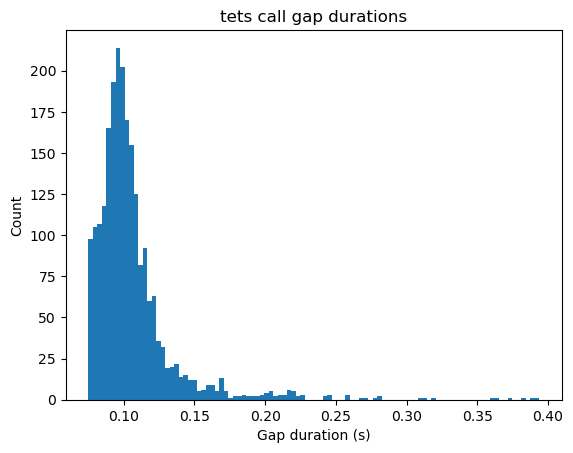

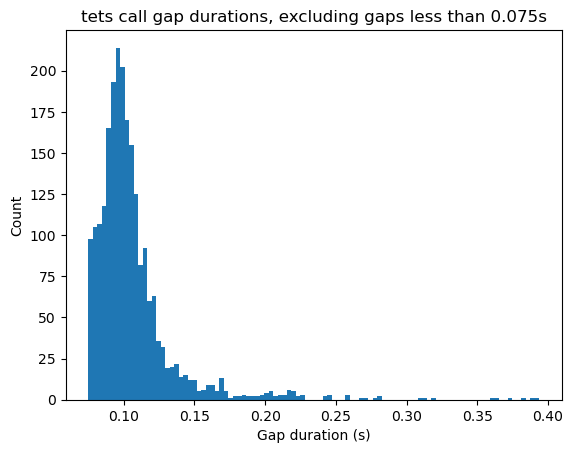

In [12]:
# ok actually we are going to exclude any tet that has a gap duration of less than 0.075 s
# find the gap durations that are less than 0.075 s, either as the initiator or the responder
# and exclude them from the analysis

# first, let's plot all the gap durations in one histogram, irrespective of who is calling
plt.figure()
all_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        all_gaps += gap_duration_dict[bird1][bird2]
plt.hist(all_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations')

# now, let's exclude the gap durations that are less than 0.075 s

plt.figure()
all_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        all_gaps += gap_duration_dict[bird1][bird2]
all_gaps = np.array(all_gaps)
all_gaps = all_gaps[all_gaps > 0.075]
plt.hist(all_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations, excluding gaps less than 0.075s')

# I need the index of all the gap durations that are less than 0.075 s so I can exclude them from the original DF
# I can then use the new DF to calculate the gap durations between each bird
# and plot the histograms again




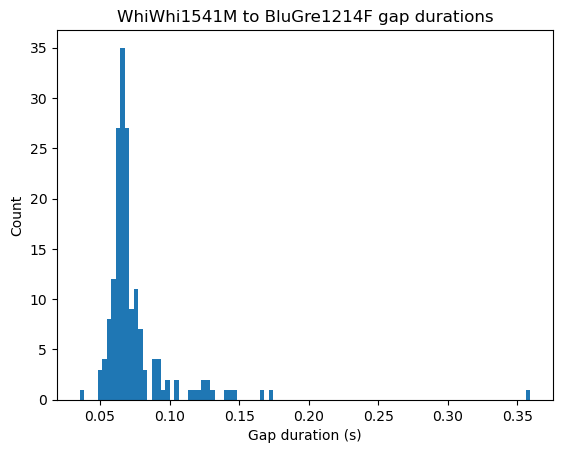

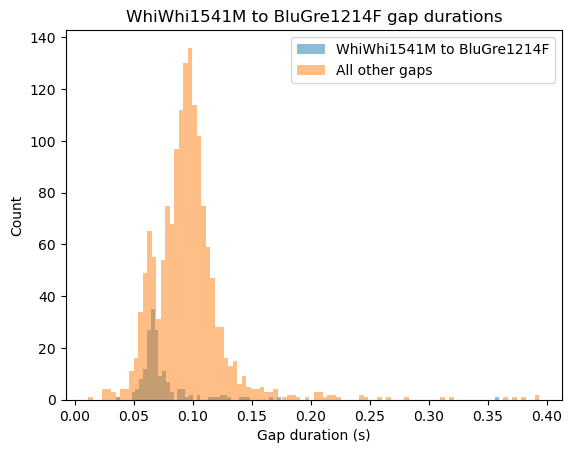

In [84]:
# plot the same histogram as above, but only for the pair of birds that has the shortest gap durations
# WhiWhi1541M to BluGre1214F
plt.figure()
plt.hist(gap_duration_dict['WhiWhi1541M']['BluGre1214F'], bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('WhiWhi1541M to BluGre1214F gap durations')

# plot the same histogram as above, contrasting with all the other gap durations combined
plt.figure()
plt.hist(gap_duration_dict['WhiWhi1541M']['BluGre1214F'], bins=100, alpha=0.5, label='WhiWhi1541M to BluGre1214F')
all_other_gaps = []
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        if bird1 != 'WhiWhi1541M' and bird2 != 'BluGre1214F':
            all_other_gaps.extend(gap_duration_dict[bird1][bird2])
plt.hist(all_other_gaps, bins=100, alpha=0.5, label='All other gaps')
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('WhiWhi1541M to BluGre1214F gap durations')
plt.legend()

# to resave the segments.csv file for Quentin, minus the polluted tets


In [96]:
raw_df = pd.read_csv(soundsep_file_name, sep=',',header=0)        
raw_df

,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords
0,0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752]
1,1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762]
2,2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041]
3,3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248]
4,4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[10.93499 7.944698 0.92982405]
...,...,...,...,...,...,...,...,...
4339,4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[12.446056 7.7917695 2.9063237]
4340,4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632]
4341,4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904]
4342,4342,BluGre1214F,2,298070022,298074525,"[""tet""]",5.0,[12.321278 9.2719965 5.2556705]


<Figure size 640x480 with 0 Axes>

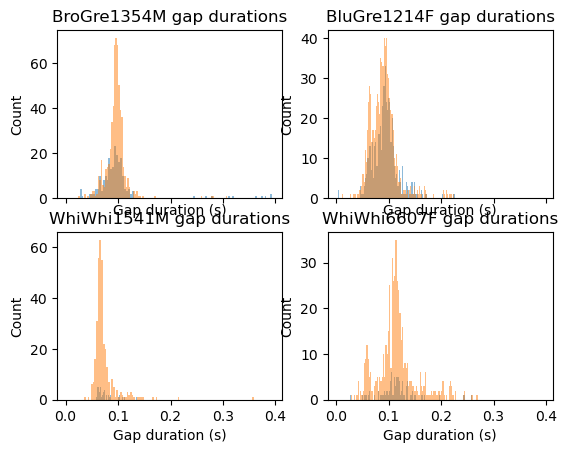

In [90]:
# plot each bird's gap durations against all others
# fix the x axis to be the same for all plots so we can compare them

plt.figure()
fig, axs = plt.subplots(2,2, sharex=True)
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
            # lump all the duratino of all other bids together
    all_other_gaps = []

    for bird2 in gap_duration_dict:
        if bird1 != bird2:
            all_other_gaps.extend(gap_duration_dict[bird1][bird2])
    # precalculate the x axis limits
    x_min = min(min(gap_duration_dict[bird1][bird1]), min(all_other_gaps))
    x_max = max(max(gap_duration_dict[bird1][bird1]), max(all_other_gaps))
    
    plt.hist(gap_duration_dict[bird1][bird1], bins=100, alpha=0.5, label=f'{bird1} to {bird1}')

    plt.hist(all_other_gaps, bins=100, alpha=0.5, label=f'{bird1} to all others')
    plt.xlabel('Gap duration (s)')

    plt.ylabel('Count')
    plt.title(f'{bird1} gap durations')
    # plt.legend()

plt.show()


<Figure size 640x480 with 0 Axes>

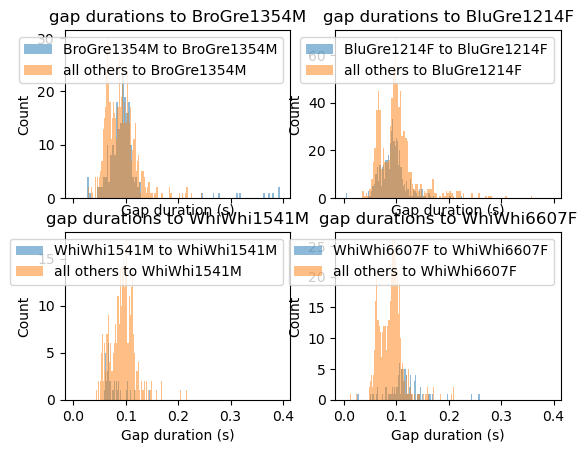

In [92]:
# plot the gap durations as a function of who is being responded to, and exluding the self responses
plt.figure()
fig, axs = plt.subplots(2,2, sharex=True)
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    all_other_gaps = []
    for bird2 in gap_duration_dict:
        if bird1 != bird2:
            all_other_gaps.extend(gap_duration_dict[bird2][bird1])
    plt.hist(gap_duration_dict[bird1][bird1], bins=100, alpha=0.5, label=f'{bird1} to {bird1}')
    plt.hist(all_other_gaps, bins=100, alpha=0.5, label=f'all others to {bird1}')
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'gap durations to {bird1}')
    plt.legend()
plt.show()

In [33]:
# let's plot how often each bird responds to each other bird in a box and whisker plot
# we'll have 4 box and whisker plots
print(f'This is how often each bird responds to each other bird')
plt.figure()
for i, bird1 in enumerate(gap_duration_dict):
    plt.subplot(2,2,i+1)
    plt.boxplot([len(gap_duration_dict[bird1][bird2]) for bird2 in gap_duration_dict[bird1]])
    plt.xticks([1,2,3,4], [bird2 for bird2 in gap_duration_dict[bird1]])
    plt.title(f'voc: {bird1}')

{'BroGre1354M': [], 'BluGre1214F': [], 'WhiWhi1541M': [], 'WhiWhi6607F': []}

## ok what's immediately noticeable is that padding with zeros is not great.  
## We could pad with silence, potentially of variable time, or at least somewhat.. Which might help extend our dataset (?)
## Ideally we would model the silence and insert that. 
## While this is promising, I want to move onto more promising things, like capturing the context of vocalizations. So I'm going to leave this for now.